## Summary

In [1]:
'''
In this project, I build a model which detects solar panels, given an aerial image
of a property.

Given the small size of the dataset, transfer learning is applied to this problem.
Images will be fed through a Convolutional Neural Network (CNN) trained on the 'ImageNet'
Dataset, with the CNN acting as a feature extractor.

A shallow neural network will be trained on these features, to identify features which
are indicative of solar power.
''';

## basic imports

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## Pre-trained Convolutional Neural Network

In [3]:
'''
Because we will be training our own classifier, we won't want to include the layer
which is able to classify classes for the original dataset. 
'''
from keras.applications.vgg16 import VGG16
conv_base = VGG16(weights = 'imagenet',       #imagenet is a dataset of objects.
                include_top = False,          #the 'top' is the classifying layer. We won't include it.
                 input_shape = (256,256,3))   #256 pixels by 256 pixels. 3 color channels for rgb.


Using TensorFlow backend.


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

## extracting features

In [5]:
'''
Credit to 'Deep Learning in Python' (Francois Chollet - the author of Keras) for the snippet below.

Within the train, test, and validation directories, images are split into two classes-
positive (having solar panel) and negative (no solar panel).

This section works images in batches. The function outputs an array of features, 
and an array of labels corresponding to those featues.
'''

from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/ubuntu/hybrid/'

train_dir = os.path.join(base_dir, 'hybrid_train')
validation_dir = os.path.join(base_dir, 'hybrid_validate')
test_dir = os.path.join(base_dir, 'hybrid_test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 233)
validation_features, validation_labels = extract_features(validation_dir, 120)
test_features, test_labels = extract_features(test_dir, 85)


Found 233 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


In [6]:
'''
By putting our images through the series of convolutional and pooling layers, we 
have output every image into a representation of the features that comprise it.

We will classify images based on these features. As valid input to our classifier, we
will reshape our sets of features.
''';

## reshaping

In [7]:
# this section reshapes the feature outputs from the feature extractor, 
# so that they can be fed directly into our classifying NN.

In [8]:
train_features = np.reshape(train_features, (233, 8 * 8 * 512))
validation_features = np.reshape(validation_features, (120, 8 * 8 * 512))
test_features = np.reshape(test_features, (85, 8 * 8 * 512))

## feeding into a Classifying Neural Network

In [9]:
'''
Will be feeding into a shallow neural network, which has activation layers, relu and sigmoid.

I will also use a Dropout layer for regularization (so that we do not send all of
our activations forward)
''';


In [10]:
from keras import models
from keras import layers
from keras import optimizers
                                                
model = models.Sequential()    
model.add(layers.Dense(256, activation='relu', input_dim=8 * 8 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,   #setting this up as a supervised problem
                    epochs=50,
                    batch_size=20,                  #feeding through in sets of 20
                    validation_data=(validation_features, validation_labels))    


Train on 233 samples, validate on 120 samples
Epoch 1/50
233/233 [==============================] - 1s 5ms/step - loss: 0.7455 - acc: 0.5494 - val_loss: 0.5971 - val_acc: 0.6667
Epoch 2/50
233/233 [==============================] - 1s 4ms/step - loss: 0.5492 - acc: 0.7210 - val_loss: 0.6712 - val_acc: 0.5500
Epoch 3/50
233/233 [==============================] - 1s 4ms/step - loss: 0.4606 - acc: 0.8069 - val_loss: 0.4990 - val_acc: 0.8500
Epoch 4/50
233/233 [==============================] - 1s 4ms/step - loss: 0.4050 - acc: 0.8369 - val_loss: 0.5167 - val_acc: 0.7250
Epoch 5/50
233/233 [==============================] - 1s 4ms/step - loss: 0.3382 - acc: 0.8755 - val_loss: 0.4684 - val_acc: 0.7667
Epoch 6/50
233/233 [==============================] - 1s 4ms/step - loss: 0.3023 - acc: 0.9185 - val_loss: 0.5302 - val_acc: 0.6833
Epoch 7/50
233/233 [==============================] - 1s 4ms/step - loss: 0.2542 - acc: 0.9485 - val_loss: 0.4054 - val_acc: 0.8417
Epoch 8/50
233/233 [==========

In [11]:
'''
This section plots our training accuracy as well as our validation accuracy.
''';

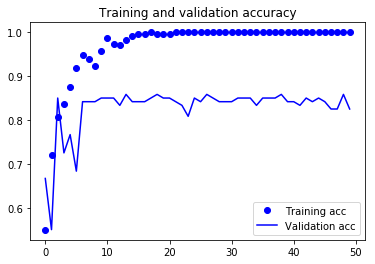

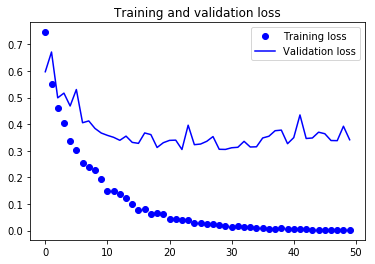

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']       #history is the model. this was where model.fit() wasd stored.
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.save('solar_panel_model2.h5')

# seeing where our model does poorly.

In [14]:
'''
Although we're seeing an accuracy of 84-85%, I'd like to see where the model misclassifies.

Because the standard feature extracting function samples randomly, it's difficult to
track the feature classifications back to the original images.

In this section, I've simply changed the 'shuffle' paramater within the original extract features function.
''';

In [15]:
'''
I"ll be getting featues of pictures, reshaping them, and them running them through the 
classifying Neural Netowrk.

Whilst the previous code has worked by being passed a parent directory of
2 class directories (positive, negative), I will now be testing on directories
which only have one or the other.

With the class pictures in isolation, I will see which images are misclassified
by the model.
''';

In [16]:
def extract_features_no_shuffle(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary',
        shuffle = False
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels



### (this will be on validation data)

In [17]:
error_pos_dir = '/home/ubuntu/error_checks/pos/'
error_neg_dir = '/home/ubuntu/error_checks/neg/'


def check_errors(directory,number_of_samples):
    error_features, error_labels = extract_features_no_shuffle(directory,number_of_samples)
    error_features = np.reshape(error_features,(number_of_samples,8*8*512))
    predictions = model.predict_classes(error_features)
    
    if directory[-4:-1] == 'neg':
        misclassified = 1
        child_directory = 'neg_folder'
    else:
        misclassified = 0
        child_directory = 'pos_folder'
    
    incorrect_image_indices = []
    for index, prediction in enumerate(predictions):
        if prediction == misclassified:
            incorrect_image_indices.append(index)
    print(incorrect_image_indices)
    
    incorrect_image_names = []
    images = os.listdir(os.path.join(directory,child_directory))
    for index in incorrect_image_indices:
        incorrect_image_names.append(images[index]) 
            
    for picture in incorrect_image_names:    
        img_path = os.path.join(directory,child_directory,picture)
        img = mpimg.imread(img_path)
        img_plot = plt.imshow(img)
        plt.show()   

Found 60 images belonging to 1 classes.
[17, 25, 34, 38, 39, 40, 45, 46, 51, 53, 55, 58]


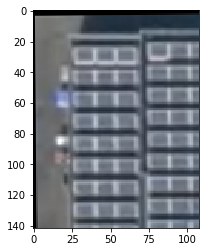

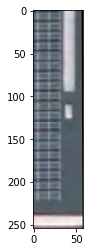

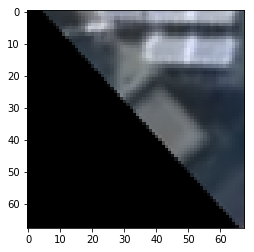

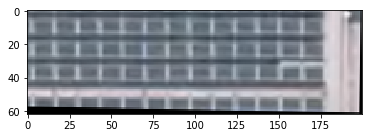

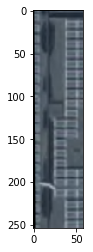

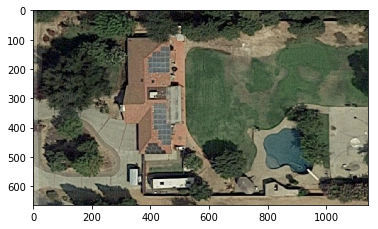

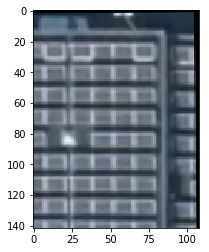

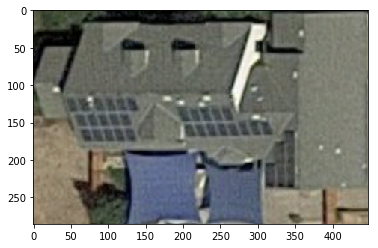

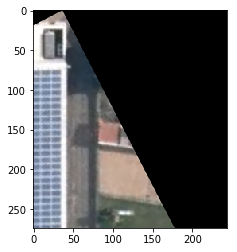

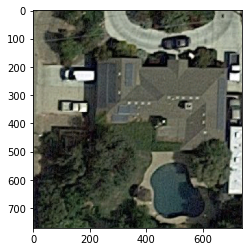

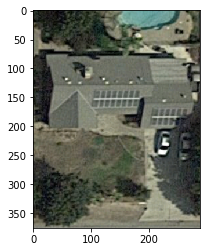

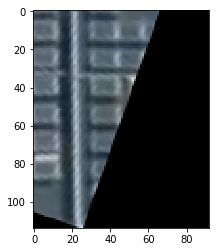

In [18]:
number_pos_samples = len(os.listdir(os.path.join(error_pos_dir,'pos_folder')))
check_errors(error_pos_dir,number_pos_samples)

In [19]:
'''
False Negatives

It seems that our model struggles most when we are point directly at a solar panel,
when there is nothing else in the image.

Considering that this model is split between residential applications and larger
farms, it may be that our model is picking up on some part of the homes which are not 
present in the larger, zoomed-in images of solar panels.

''';


Found 60 images belonging to 1 classes.
[31, 38, 42, 43, 47, 51, 54, 55, 56]


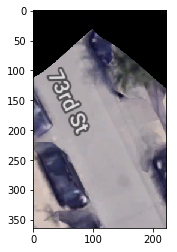

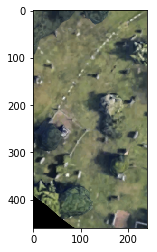

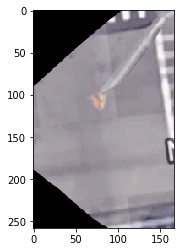

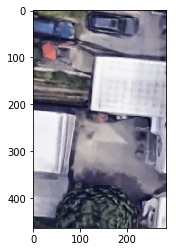

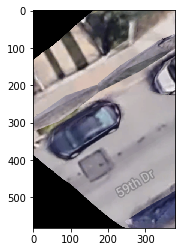

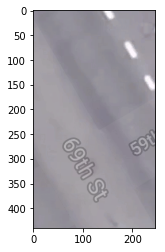

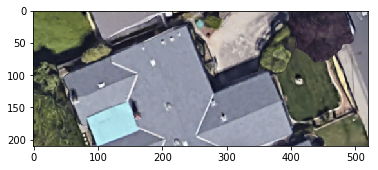

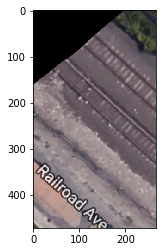

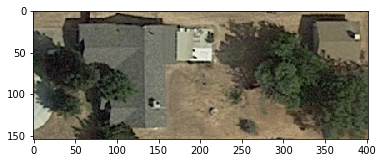

In [20]:
number_neg_samples = len(os.listdir(os.path.join(error_neg_dir,'neg_folder')))
check_errors(error_neg_dir,number_neg_samples)

In [21]:
'''
False Positives

Images often have rectangular structures within them.
I wonder if these are the features which are getting incorrectly classified as
solar panels.
''';




## checking model on hand-selected roofs

In [22]:
'''
'without_panel_1.png' is a home with no solar power
'with_panel_1.png' is a home with solar power
'only_panel.png' is the panel portion by itself.

'''
os.listdir('roofs/inside')

['without_panel_1.png', 'with_panel_1.png', 'only_panel.png']

In [23]:
roof_dir = 'roofs'
roof_features, roof_labels = extract_features_no_shuffle(roof_dir,3)

Found 3 images belonging to 1 classes.


In [24]:
roof_features = np.reshape(roof_features,(3,8*8*512))

In [25]:
model.predict(roof_features,3)

array([[0.58465904],
       [0.69924134],
       [0.92744106]], dtype=float32)